Code hosted at: https://github.com/sansomguy/OnTrack_Public/blob/main/Task_4_1D_SIT796.ipynb

# C.1 Traffic Control Environment

In [ ]:
import gym
from gym import spaces
import numpy as np
import random as rand

class SimpleTrafficControlEnv(gym.Env):
  # create properties required for representing 
  # and update state of our traffic intersection
  def __init__(self):
    super(SimpleTrafficControlEnv, self).__init__()
    # action & observation spaces
    self.action_space = spaces.Discrete(2)
    self.observation_space = spaces.Discrete(4)
    self.state = np.array([1,0,0,0])
    # state names for use in lookups of transition and rewards dictionaries
    self.states = [
      'PhaseMain,TrafficMain',
      'PhaseMain,TrafficLeft',
      'PhaseLeft,TrafficMain',
      'PhaseLeft,TrafficLeft'
    ]
    # action names for use in lookups of transition and rewards dictionaries
    self.actions = [
      'PhaseMain',
      'PhaseLeft'
    ]
    # define our known discrete mdp environment
    # first we define our transition probabilities with respect to stochasticity mentioned in 2.2 above.
    self.transition_probs = {
        'PhaseMain,TrafficMain': {
            'PhaseMain': { 'PhaseMain,TrafficMain': 0.9, 'PhaseMain,TrafficLeft': 0.1},
            'PhaseLeft': { 'PhaseLeft,TrafficMain': 0.9, 'PhaseLeft,TrafficLeft': 0.1}
        },
        'PhaseMain,TrafficLeft': {
            'PhaseMain': { 'PhaseMain,TrafficMain': 0.2, 'PhaseMain,TrafficLeft': 0.8},
            'PhaseLeft': { 'PhaseLeft,TrafficLeft': 0.7, 'PhaseLeft,TrafficMain': 0.3}
        },
        'PhaseLeft,TrafficMain': {
            'PhaseLeft': { 'PhaseLeft,TrafficMain': 0.9, 'PhaseLeft,TrafficLeft': 0.1},
            'PhaseMain': { 'PhaseMain,TrafficMain': 0.9, 'PhaseMain,TrafficLeft': 0.1}
        },
        'PhaseLeft,TrafficLeft': {
            'PhaseLeft': { 'PhaseLeft,TrafficLeft': 0.7, 'PhaseLeft,TrafficMain': 0.3 },
            'PhaseMain': { 'PhaseMain,TrafficLeft': 0.6, 'PhaseMain,TrafficMain': 0.4 }
        }
    }
    # rewards defined in section 2.3 above
    self.rewards = {
      'PhaseMain,TrafficMain': { 
          'PhaseMain': { 'PhaseMain,TrafficMain': +1, 'PhaseMain,TrafficLeft': -2},
          'PhaseLeft': { 'PhaseLeft,TrafficLeft': +1, 'PhaseLeft,TrafficMain': -2}
      },
      'PhaseLeft,TrafficMain': {
          'PhaseMain': {'PhaseMain,TrafficMain': +1, 'PhaseMain,TrafficLeft': -2},
          'PhaseLeft': {'PhaseLeft,TrafficLeft': +1, 'PhaseLeft,TrafficMain': -2}
      },
      'PhaseMain,TrafficLeft': {
          'PhaseMain': {'PhaseMain,TrafficMain': +1, 'PhaseMain,TrafficLeft': -2},
          'PhaseLeft': {'PhaseLeft,TrafficLeft': +1, 'PhaseLeft,TrafficMain': -2}
      },
      'PhaseLeft,TrafficLeft': {
          'PhaseMain': {'PhaseMain,TrafficMain': +1, 'PhaseMain,TrafficLeft': -2},
          'PhaseLeft': {'PhaseLeft,TrafficLeft': +1, 'PhaseLeft,TrafficMain': -2}
      }
    }
    rand.seed(None)

  # clean state
  def reset(self):
    # set initial state to PhaseMain,TrafficMain
    return np.array([1,0,0,0])

  # step through time using new action
  def step(self, action):
    old_state = self.get_state_name(self.state)
    # perform state updates based on new action
    self._perform(action) 
    new_state = self.get_state_name(self.state)
    # calculate reward
    reward = self.get_reward(old_state, self.actions[action], new_state) 

    # return new observations as well as reward
    # and done is always False in this environment
    return self.state, reward, False, {}
  
  def get_reward(self, state, action, next_state):
    if next_state in self.rewards[state][action]:
      return self.rewards[state][action][next_state]
    return -10 # large negative reward if attempting illegal move

  # given current state, and action, determine transition probability for new state
  def get_transition_prob(self, state, action, next_state):
    if next_state in env.transition_probs[state][action]:
      return env.transition_probs[state][action][next_state]
    return 0.0

  # update discrete space observation given state index
  def _set_state(self, state_index):
    new_state = np.array([0,0,0,0])
    new_state[state_index] = 1
    self.state = new_state

  # perform the state updates given selected action
  def _perform(self, action):
    assert self.action_space.contains(action)
    action_name = self.actions[action]
    new_state = self._get_new_state(action)
    self._set_state(self.states.index(new_state))

  def _get_new_state(self, action):
    # get a random number to use as the stochasticity
    # for action transitions
    random_value = rand.random()
    state_name = self.get_state_name(self.state)
    # get the non-zero transition probabilities for current state
    # from the transition probabilities dictionary
    transitions = self.transition_probs[state_name][self.actions[action]]
    
    # convert dictionary into tuple list
    # so that we can sort the list based on probability of transition
    items_list = [(k,v) for k,v in transitions.items()]
    items_list.sort(key=lambda x: x[1], reverse=True)

    # if the highest transition probability is greater
    # than the random number then we use that as the new state
    if random_value < items_list[0][1]:
      return items_list[0][0] # return the action with the highest probability
    else: # else we return a state with the lower probability of occurrence
      return items_list[1][0]

  # given discrete state space value, get the string representation of the state
  # this can then be used in lookup tables
  def get_state_name(self, state):
    return self.states[state.tolist().index(1)]




env = SimpleTrafficControlEnv()


#C.2 State-Action Value
*Based on code in Practical 3.*

In [1]:
''' 
  Given state-action pair and existing value function, 
  find the value of state using the bellman equation
'''
def get_action_value(env, state_values, state, action, gamma):
    
    # Bellman equation for total reward at state
    state_value = 0  
    for s in env.states:
      
      state_value = state_value + env.get_transition_prob(state, action, s)*(env.get_reward(state, action, s) + gamma*state_values[s]) 
    return state_value

# C.3 State Value Function
*Based on code in practical 3.*

In [ ]:
def get_new_state_value(env, state_values, state, gamma):
    import numpy as np

    # Initialise the dict
    A = [a for a in env.actions]
    v = np.zeros(len(env.actions))
    
    # Compute all possible options
    for i,a in enumerate(env.actions):
      v[i] = get_action_value(env, state_values, state, a, gamma)
      A[i] = a

    # Recover V(s) and π∗(s) as per the formula above
    V = {A[np.argmax(v)]:v[np.argmax(v)]}
    
    return V

# C.4 Value Iteration Loop
*Based on code found in practical 3.*

In [ ]:
import time

# parameters
gamma = 0.8
num_iter = 1000
# close enough to optimal value function
tolerance = 0.0001

# initialize V(s)
vi_state_values = {s:-10 for s in env.states}

start_time = time.time()

for i in range(num_iter):
    new_state_values = {}
    for s in env.states:
      nsv = get_new_state_value(env, vi_state_values, s, gamma)
      a = list(nsv)[0]
      v = nsv[a]
      new_state_values[s] = v

    # Compute difference
    diff = max(abs(new_state_values[s] - vi_state_values[s]) for s in env.states)
    vi_state_values = new_state_values

    if diff < tolerance:
        break

# Create updated policy from VI state values
vi_policy = {s: 0 for s in env.states}
for s in env.states:
  action = list(get_new_state_value(env, vi_state_values, s, gamma))[0]
  vi_policy[s] = action

finished_time = time.time()

print("Duration: {}".format(finished_time - start_time))


Duration: 0.01125025749206543


# C.5 Policy Evaluation

In [ ]:
def get_pi_new_state_value(env, policy, state_values, state, gamma):
  value = 0
  for s in env.states:
    action = policy[state]
    reward = env.get_reward(state, action, s)
    transition_prob = env.get_transition_prob(state, action, s)
    value += transition_prob*(reward + gamma*state_values[s])
  return value

# C.6 Policy Improvement

In [ ]:
def update_policy(env, policy, state_values, gamma):
  has_changed = False
  for s in env.states:
    a = policy[s]
    # find the best action
    # given our state_values
    action_index = np.argmax([get_action_value(env, state_values, s, action, gamma) for action in env.actions])
    new_action = env.actions[action_index]
    policy[s] = new_action

    # check if we have changed at all
    if new_action != a:
      has_changed = True

  return has_changed


# C.7 Policy Iteration Loop

In [ ]:
# initialize
pi_state_values = {s:0 for s in env.states}
policy = {s:env.actions[0] for s in env.states}
gamma = 0.8
has_changed = True
start_time = time.time()
# start
while has_changed:
  # calculate value for each state based on policy
  for s in env.states:
    pi_state_values[s] = get_pi_new_state_value(env, policy, pi_state_values, s, gamma)
  # improve policy
  for s in env.state:
    has_changed = update_policy(env, policy, pi_state_values, gamma)

finished_time = time.time()
print("Duration: {}".format(finished_time - start_time))
pi_policy = policy

Duration: 0.0006430149078369141


# C.8 State-Value MDP Graph
*Graph exporting code is sampled from practical 3.*

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Value iteraton MDP


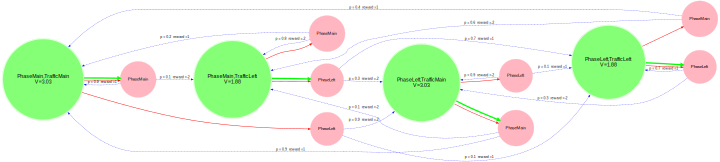

Policy iteration MDP


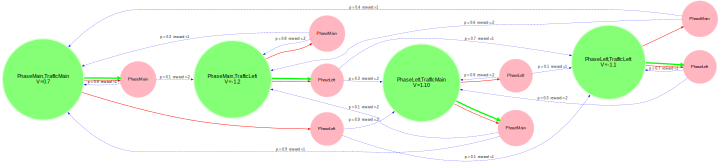

In [ ]:
from google.colab import drive
import sys
drive.mount('/content/drive')
sys.path.insert(0,'/content/drive/MyDrive/Colab Notebooks')
import mdp


import sys, os
if 'google.colab' in sys.modules and not os.path.exists('.setup_complete'):
  !setup_colab_practical3.sh -O- | bash
  !touch .setup_complete

if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY")) == 0:
    !bash ../xvfb start
    os.environ['DISPLAY'] = ':1'


from mdp import has_graphviz, MDP
from IPython.display import display

def get_plot_action_value(mdp, state_values, state, action, gamma):
  return get_action_value(env, state_values, state, action, gamma)

if has_graphviz:
  from mdp import plot_graph, plot_graph_with_state_values, plot_graph_optimal_strategy_and_state_values
  mdp = MDP(env.transition_probs, env.rewards, initial_state='PhaseMain,TrafficMain')
  print("Value iteraton MDP")
  display(plot_graph_optimal_strategy_and_state_values(mdp, vi_state_values, get_plot_action_value))
  print("Policy iteration MDP")
  display(plot_graph_optimal_strategy_and_state_values(mdp, pi_state_values, get_plot_action_value))
else:
  print("Graphviz not available")

# C.9 Value Iteration Test

In [ ]:
TIME_LIMIT = 1000

# Create new traffic control gym environment
total_reward = []
# Reset to clear state from potentialy earlier runs
o = env.reset() 
# for each time step
for t in range(TIME_LIMIT):
    # choose action from policy iteration model
    action = vi_policy[env.states[o.tolist().index(1)]]
    # take step given action
    o, r, d, _ = env.step(env.actions.index(action))
    total_reward += [r]
else:
    print("Time limit reached.")
    print("Average reward {0}".format(np.mean(total_reward)))

Time limit reached.
Average reward 0.568


# C.10 Policy Iteration Test

In [ ]:
TIME_LIMIT = 1000

# Create new traffic control gym environment
total_reward = []
# Reset to clear state from potentialy earlier runs
o = env.reset() 
# for each time step
for t in range(TIME_LIMIT):
    # choose action from policy iteration model
    action = pi_policy[env.states[o.tolist().index(1)]]
    # take step given action
    o, r, d, _ = env.step(env.actions.index(action))
    total_reward += [r]
else:
    print("Time limit reached.")
    print("Average reward {0}".format(np.mean(total_reward)))

Time limit reached.
Average reward 0.568
